In [66]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from scipy.stats import uniform
%matplotlib inline  

# 1) Build an MC algorithm that computes the mean of any given distribution
You will train your algorithm on the following density mixture_d_2. If your algorithm needs to be restricted to a compact set. You can only choose $[-10,10]^2$ but it is not allowed to take $[0,10]^2$ (this information is obtained by visualizing which is not always the case). You will first present your algorithm and then evaluate its performance according to different budget $(1000,5000,10000)$ using the averaged squared error computed over, at least, $50$ trials. If $A_1,\ldots, A_{50}$ are realization of your algorithm and $\mu$ is the true value, the average squared error computed over $50$ trials is
$$\frac{1}{50} \sum_{i=1} ^{50} (A_i - \mu)^2$$ 


In [67]:
def mixture_d_2(x):
    return (.2*np.exp(-(x[0]-3)**2/2)*np.exp(-(x[1]-7)**2/2) + .4*np.exp(-(x[0]-7)**2/2)*(np.exp(-(2-x[1])**2/2) + np.exp(-(7-x[1])**2/2)))/(2*np.pi)

true_mu = np.array([6.2,5])

# Here is a plot of the density

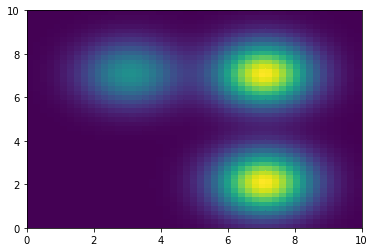

In [68]:
def plot(func,end = True):
    N = 50
    z = np.zeros([N,N])
    x = np.zeros([N,N])
    y = np.zeros([N,N])
    xmin = 0
    xmax = 10
    ymin = 0
    ymax = 10

    x1 = np.linspace(xmin,xmax,N)
    y1 = np.linspace(ymin,ymax,N)
    for i in range(N):
        for j in range(N):
            x[i,j] = x1[i]
            y[i,j] = y1[j]
            z[i,j] = func([x1[i],y1[j]])

    plt.pcolormesh(x,y,z)
    if end:
        plt.show()

plot(mixture_d_2)

### Naive estimation

To start the estimation we visit the space with a uniform distribution on $[ -10,10 ]^2$ 

In [155]:
def uniform_array(size,dim):
    return (uniform.rvs(size=(size,dim)))*20 -10

budget = 5000
n1 = int(np.sqrt(budget))
X = uniform_array(n1,2)
phi = list(map(mixture_d_2,X))
sum_phi = np.array(phi).sum()
mu = (phi @ X)/sum_phi

s_part1 = np.zeros(2)
for i in range(n1):
    s_part1+= mixture_d_2(X[i])*X[i]*400
#s_part1/=n1

print(s_part1/n1)

[4.46791686 5.74985495]


### Max likelihood approach

We chose the gaussian method, as a proof of concept we estimate the distribution in 2d but it will be generalised later.
The parameter we have to find are the esperance $\mu$ and the covaraince matrix $\Sigma$.

[6.05141007 3.95608874] 
 [[ 4.01120234 -3.83734745]
 [-3.83734745  8.06728316]]


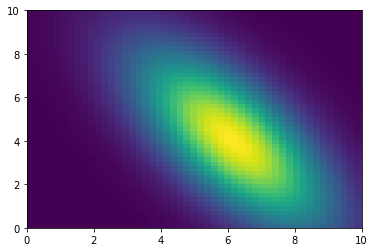

In [70]:
sig1 = ((X[:,0] - mu[0]).T @  np.diag(phi) @ (X[:,0] - mu[0]))/sum_phi
sig2 = ((X[:,1] - mu[1]).T @  np.diag(phi) @ (X[:,1] - mu[1]))/sum_phi
sig12= ((X[:,1] - mu[1]).T @  np.diag(phi) @ (X[:,0] - mu[0]))/sum_phi

sig = np.matrix([[sig1,sig12],[sig12,sig2]])
print(mu,'\n',sig)

var = multivariate_normal(mean=mu, cov=sig)

plot(var.pdf)

Now that we have the estimation of the distribution we generate point according to it and calculate the mean.

In [71]:
n2 = budget - n1

s_part2=np.zeros(2)
for i in range(n2):
    temp = var.rvs()
    s_part2+= mixture_d_2(temp)*temp/var.pdf(temp)
#s_part2 /= n2
print((s_part1 + s_part2)/budget)

[5.70098819 4.57138301]


This is a more general implementation. Let's try the method over 50 trials with budget 1000, 5000, 10000

Finally we tried to iterate several time the likelihood method to see how it compared to the other methods.

The budget split allocates a significant part of the budget to the native exploration of the space in order to make sure we get all the information about the function. Then the rest of the budget is used on the samplers that were built using this information. We allocate more evaluations at each step as the sampler becomes more optimal. 

In [72]:
def budget_split(budget,bsize):
    n = [int((budget-int(budget/bsize))/(2**i)) for i in range(bsize-1,0,-1)]
    n[-1] += budget-int(budget/bsize)-sum(n)
    return [int(budget/bsize)]+n

In [176]:
def likelihood_eval_batch(budget,func,dim,bsize):
    #naive visit
    n = budget_split(budget,bsize)
    #print(n)
    weigth = []
    s = np.zeros((bsize,dim))
    X = uniform_array(n[0],dim)
    
    phi = list(map(func,X))
    weigth+= list(map(lambda x: x*20**dim,phi))

    
    for k in range(1,len(n)):
        sum_weigth = sum(weigth)
        # likelihood update
        mu = (weigth @ X)/sum_weigth
        s[k-1] = mu.copy()
        #print('mu : ', mu)
        sig  = np.zeros((dim,dim))
        for i in range(dim):
            for j in range(i,dim):
                sig[i,j] = sig[j,i] = ((X[:,i] - mu[i]).T @  np.diag(weigth) @ (X[:,j] - mu[j]))/sum_weigth
        #print('sig : ',sig)
        var = multivariate_normal(mean=mu, cov=sig)
        # evalutaion
        X_new = var.rvs(size=n[k])
        #plt.scatter(X_new[:,0],X_new[:,1])
        #plt.show()
        phi = list(map(func,X_new))
        weigth+= list(phi/var.pdf(X_new))
        X = np.concatenate((X,X_new),axis=0) 
        #print((weigth @ X))
        #print(n[:k+1])
    s[-1] = (weigth @ X)/sum(weigth)
    return s


We take note of the value of the mean squared error durring at each step to comparte with other algorithm.

In [96]:
avg_eval_likely_batch = np.zeros((3,4))

for j in range(50):
    avg_eval_likely_batch[0] += np.sum((likelihood_eval_batch(1000,mixture_d_2,2,4)-true_mu)**2,axis=1)
    avg_eval_likely_batch[1] += np.sum((likelihood_eval_batch(5000,mixture_d_2,2,4)-true_mu)**2,axis=1)
    avg_eval_likely_batch[2] += np.sum((likelihood_eval_batch(10000,mixture_d_2,2,4)-true_mu)**2,axis=1)
    
avg_eval_likely_batch /= 50

In [177]:
print("Error for a budget of 1000: ",avg_eval_likely_batch[0][-1])
print("Error for a budget of 5000: ",avg_eval_likely_batch[1][-1])
print("Error for a budget of 10000: ",avg_eval_likely_batch[2][-1])

Error for a budget of 1000:  0.2108560554343759
Error for a budget of 5000:  0.05766764205147831
Error for a budget of 10000:  0.019702208647900225


### Metropolis Hastings method

To start we will make a naive visit using a uniform distribution then for each point we will start a markov chain so as not to miss any maxima of the function we are trying to estimate. The kernel we will use is the gaussian kernel.

In [166]:
sigma = 1

def metro_hasting(X0,budget,func):
    chain = [X0]
    values =[func(X0)]
    dim=len(X0)
    var = multivariate_normal(mean=X0, cov=np.identity(dim)*sigma)
    for i in range(budget):
        Xnext  = list(var.rvs())
        chain.append(Xnext)
        values.append(func(Xnext))
        if  min(1,func(Xnext)/func(X0)) > np.random.random():
            var = multivariate_normal(mean=Xnext, cov=np.identity(dim)*sigma)         
    return chain,values


Test of the metropolis hasting on points [5,5] (close to the region of interest), with 1000 points to check if the implementation is correct.

In [131]:
X55, phi = metro_hasting([5,5],1000,mixture_d_2)
X55 = np.array(X55)

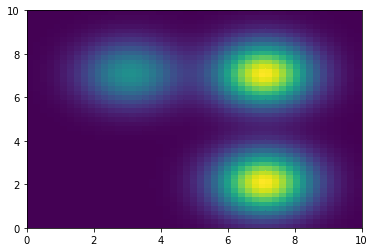

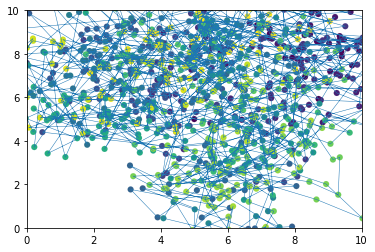

In [132]:
plot(mixture_d_2)

fig1 = plt.figure()
plt.xlim(0,10)
plt.ylim(0,10)
plt.scatter(X55[:,0],X55[:,1],c=[i for i in range(len(X55))],linewidth= 0.1)
l1 = plt.plot(X55[:,0],X55[:,1],linewidth=0.5)
plt.show()

Now the true implementation starts with a naive visit following $~ \mathcal{U} [-10,10]^2 $ and for the quater of point where the function takes the greatest values, we start a Markov Chain.

In [133]:
def multi_metro_hasting(budget,func,dim,n1,imp):
    #faster
    X = list(uniform_array(n1,dim))
    #X = [[np.random.uniform(-10,10) for j in range(dim)] for i in range(n1)]
    phi = list(map(func,X))
    ## implementation 1
    # we only take a quarter of the sample so as not to start on point that have very low values
    if imp == 1: 
        order = np.argsort(phi)[::-1][0:int(n1/4)]
        for i in range(len(order)):
            Xt,phit = metro_hasting(X[order[i]],(budget-n1)//int(n1/4),func)
            X+=Xt
            phi+=phit
    # implementation 2
    # we bootstrap from the sample the starting points given by the naive visit at each of the resampled point we start 
    # an new markov chain
    if imp ==2:
        q = np.array(phi)/sum(phi)
        draw = np.random.multinomial(int(n1/8),q)
        for i in range(len(draw)):
            for j in range(draw[i]):
                Xt,phit = metro_hasting(X[i],(budget-n1)//int(n1/8),func)
                X+=Xt
                phi+=phit
    return np.array(X).T #,phi

We expect the second approach to be better with greater n1 but to be sure we compare 

In [134]:
X1p = []
X2p = []
for n in [100*i for i in range(1,11)]:
    X1s = 0
    X2s = 0
    for i in range(10):
        X1 = multi_metro_hasting(1000,mixture_d_2,2,n,1)
        X2 = multi_metro_hasting(1000,mixture_d_2,2,n,2)
        X1 = np.array(X1)
        X2 = np.array(X2)
        #print((np.sum(X1,axis=1)/X1.shape[1]- true_mu)**2)
        X1s+=np.sum((np.sum(X1,axis=1)/X1.shape[1]- true_mu)**2)
        #print(X1s)
        X2s+=sum((np.sum(X2,axis=1)/X2.shape[1]- true_mu)**2)
    X1p.append(X1s/10)
    X2p.append(X2s/10)

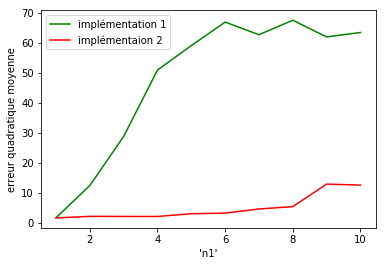

In [135]:
plt.plot([i+ 1 for i in range(10)], X1p, 'g',label = 'implémentation 1')
plt.plot([i+ 1 for i in range(10)], X2p, 'r',label = "implémentaion 2")
plt.legend(loc='upper left')
plt.xlabel("'n1'")
plt.ylabel("erreur quadratique moyenne")
plt.show()

The second implementation seems always better so that's what we will use in the tests. we will use $n_1 \approx \frac{\text{budget}}{10}$  

In [ ]:
for n in [1000,5000,10000]:
    Xs = 0
    for i in range(50):
        X1 = multi_metro_hasting(n,mixture_d_2,2,int(n/10),2)
        X1 = np.array(X1)
        Xs+=np.sum((np.sum(X1,axis=1)/X1.shape[1]- true_mu)**2)
    if n == 1000:
        Xk=Xs/50
    if n == 5000:
        X5k=Xs/50
    if n == 10000:
        X10k=Xs/50

In [138]:
print("Error for a budget of 1000: ",Xk)
print("Error for a budget of 5000: ",X5k)
print("Error for a budget of 10000: ",X10k)

Error for a budget of 1000:  1.5864975422863525
Error for a budget of 5000:  0.5765063864153624
Error for a budget of 10000:  0.4950612070356673


The Metropolis-Hastings algorithm did not give us good results. We weren't able to find a set of parameters to make it have a good performance. 

### Non parametric approach (kernel method)

The kernel that we chose to use is a gaussian kernel : $g \mapsto \frac{e^{||x||^2}}{(2 \pi )^{\frac{d}{2}}}$

In [12]:
def gauss_kernel(x):
    return np.exp((-1/2)*(x.T @ x))/(np.sqrt(2*np.pi)**len(x))

The factor due to the dimension is taken into account in another function.

The way we draw from the density we constuct is by first drawing from a multinomial with the weigth as parameters and then from a gaussain distibution centrered around the point associated with said weigth, the variance is made to decrease as the iterations go and its values were selected empirically with what seemed to match the data.

In [139]:
from scipy.stats import multinomial

def generate(n,q,X,d,h):
    X2=[]
    draw = np.random.multinomial(n,q)
    Id = np.identity(d)
    for i in range(len(draw)):
        for j in range(draw[i]):
            x2=np.random.multivariate_normal(X[i],Id*h**2)
            X2.append(x2)
    return(np.array(X2))

This update function returns a $\text{q}_{i+i} $ from the $X$ already visited, the unnormalised weigth $w$, the dimension $d$ and the size of the window $h$.

In [14]:
def update_sampler(X,w,d,h):
    w=w/np.sum(w)
    def q(x):
        K=np.array(list(map(gauss_kernel,(x-X)/h)))/h
        return (w@K)
    return q,w


## to plot the density of the current sampler 
def plot_sampler(q,step):
    N = 50
    z = np.zeros([N,N])
    x = np.zeros([N,N])
    y = np.zeros([N,N])
    xmin = 0
    xmax = 10
    ymin = 0
    ymax = 10

    x1 = np.linspace(xmin,xmax,N)
    y1 = np.linspace(ymin,ymax,N)
    for i in range(N):
        for j in range(N):
            x[i,j] = x1[i]
            y[i,j] = y1[j]
            z[i,j] = q([x1[i],y1[j]])

    plt.pcolormesh(x,y,z)
    plt.title("Sampler after step "+str(step))
    plt.show()

We now can implement the adaptive important sampling method for a non-parametric sampler. The function takes in argument the list of budgets allocated to each iteration of the algorithm, h, the list of window sizes, d the dimension of the problem, and (a,b) defining the hypercube $[a,b]^{d}$ we wish to initialy explore. It returns the value of the expectation and plots of the density at each iteration. 

In [15]:
### implementation of the regular AIS 
def AIS(N_list,a,b,d,h,plot):
    
    N = N_list[0]
    step=1
    
    #initial naïve uniform visit of the space 
    X = (b-a)* np.random.random_sample((N, d)) + a 
    phi = np.array(list(map(mixture_d_2,X)))
    weight=phi*(b-a)**2
    S=np.dot(X.T,weight)
    
    #update of the sampler
    q,w=update_sampler(X,weight,d,h[0])
    
    if plot == True:
        plot_sampler(q,step)
        
    for n,hi in zip(N_list[1:],h[1:]):
    
        X=generate(n,w,X,d,hi)
        phi = np.array(list(map(mixture_d_2,X)))
        qX = np.array(list(map(q,X)))
        weight=phi/qX
        S+=np.dot(X.T,weight)
        N+=n
        q,w=update_sampler(X,weight,d,hi)
        step+=1
        I=S/N
        if plot == True:
            plot_sampler(q,step)
               
    return I

Let's test this method with an example to see if the results are coherent. 

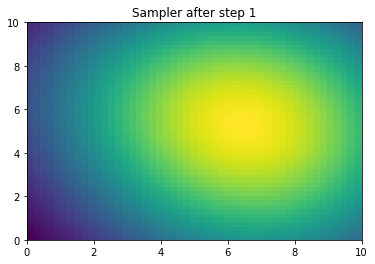

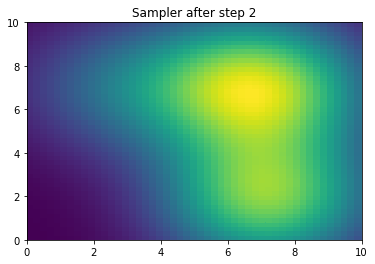

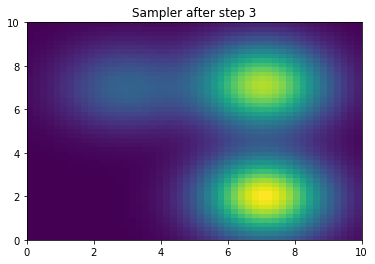

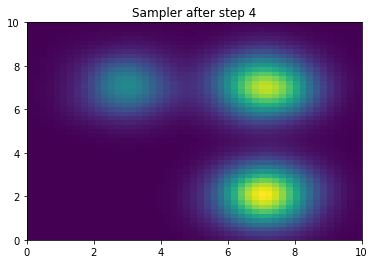

The expectation is [6.34708617 4.96697482]


In [140]:
I=AIS(budget_split(10000,4),-10,10,2,[4,2,1,0.5],True)
print('The expectation is',I)

We see that the sampler converges to something proportianal the the target density, however we see that the value of the expectation is only proportional to the true value. This means that this function does not perfectly integrate constants. Not being able to find where this consistant error is caused we decided to go for another approach which suppresses this problem. We chose to implement a normalised AIS algorithm.

In [23]:
def normalised_AIS(N_list,func,d,h,plot):
    partial = []
    a=-10
    b=10
    N=N_list[0]
    X= uniform_array(N, d)
    phi = np.array(list(map(func,X)))
    weight=phi*(b-a)**2
    S1=np.dot(X.T,weight)
    S2=np.sum(weight)
    partial.append(S1/S2)
    q,w=update_sampler(X,weight,d,h[0])
    step=1
    if plot == True:
        plot_sampler(q,step) 
    for n,hi in zip(N_list[1:],h[1:]):
        X=generate(n,w,X,d,hi)
        phi = np.array(list(map(func,X)))
        temp =np.array(list(map(q,X)))
        weight=phi/temp
        S1+=np.dot(X.T,weight)
        S2+=np.sum(weight)
        partial.append(S1/S2)
        N+=n
        q,w=update_sampler(X,weight,d,hi)
        step+=1
        
        if plot == True:
            plot_sampler(q,step)
               
    return np.array(partial)

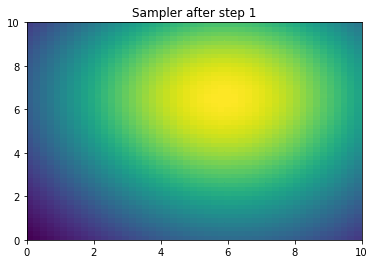

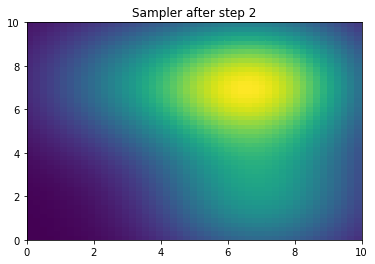

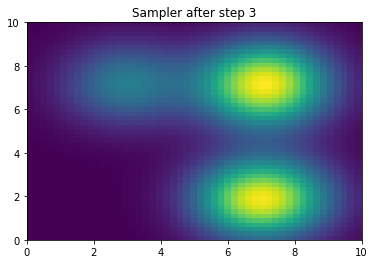

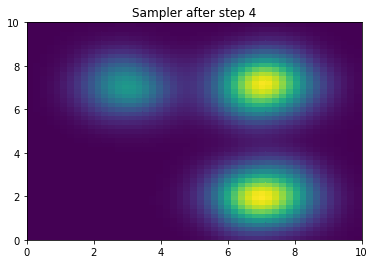

The expectation is [6.20210807 4.99325285]


In [95]:
I=normalised_AIS(budget_split(10000,4),mixture_d_2,2,[4,2,1,0.5],True)
print('The expectation is',I[-1])

The results with this algorithm seem satisfactory, let's confirm this by looking at the error.

In [124]:
NAISk = np.zeros(4)
NAIS5k = np.zeros(4)
NAIS10k = np.zeros(4)

for i in range(50):
    NAISk += ((normalised_AIS(budget_split(1000,4),mixture_d_2,2,[4,2,1,0.5],False)-true_mu)**2).sum(axis=1)
    NAIS5k += ((normalised_AIS(budget_split(5000,4),mixture_d_2,2,[4,2,1,0.5],False)-true_mu)**2).sum(axis=1)
    NAIS10k += ((normalised_AIS(budget_split(10000,4),mixture_d_2,2,[4,2,1,0.5],False)-true_mu)**2).sum(axis=1)
    
NAISk /= 50
NAIS5k /= 50
NAIS10k /= 50

print("Error for a budget of 1000: ",NAISk[-1])
print("Error for a budget of 5000: ",NAIS5k[-1])
print("Error for a budget of 10000: ",NAIS10k[-1])

Error for a budget of 1000:  0.08345261363392746
Error for a budget of 5000:  0.018694742816505103
Error for a budget of 10000:  0.010647853037394748


Let's look at the evelution of the mean squared error at each iteration to see the influence of the updated sampler

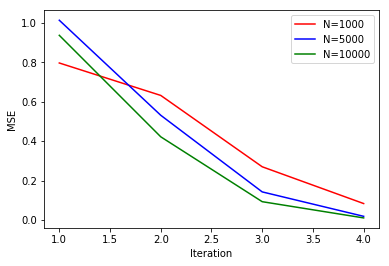

In [129]:
plt.figure()
plt.plot([i+1 for i in range(4)],NAISk,'r',label='N=1000')
plt.plot([i+1 for i in range(4)],NAIS5k,'b',label='N=5000')
plt.plot([i+1 for i in range(4)],NAIS10k,'g',label='N=10000')
plt.legend(loc='upper right')
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.show()

We see on the graph that the error decreases significantly at each iteration as excepted.

# 2) Compare your algorithm to the basic MC methods with uniform sampling on the cube [0,10]^2
(note that such a method has an additional information with respect to yours, which is the suppoet information [0,10]^2)

The comparison will be made with respect to a budget of $10000$ particles using the average squared error computed over at least $50$ trials.

In [86]:
# Monte Carlo method on [0,10]^2


def random_eval(dim):
    x = np.array((np.random.uniform(0,10) , np.random.uniform(0,10)))
    return mixture_d_2(x)*10**dim*x

def MC(budget,func,dim):
    s = np.zeros(2)
    for i in range(budget):
        #X = np.array([[np.random.uniform(-10,10) for j in range(dim)] for i in range(budget)])
        s+= random_eval(dim)
    s/=budget
    return s

MCK  =0
MC5K =0
MC10K=0

for i in range(50):
    MCK   += ((MC(1000,mixture_d_2,2)-true_mu)**2).sum()
    MC5K  += ((MC(5000,mixture_d_2,2)-true_mu)**2).sum()
    MC10K +=((MC(10000,mixture_d_2,2)-true_mu)**2).sum()

MCK   /=50
MC5K  /=50
MC10K /=50

print(MCK,MC5K,MC10K)

0.1731417793703615 0.041419832925316646 0.022731526438575927


Now that we can compare each algorithm to see which one performs the best. 

Text(0,0.5,'Best error')

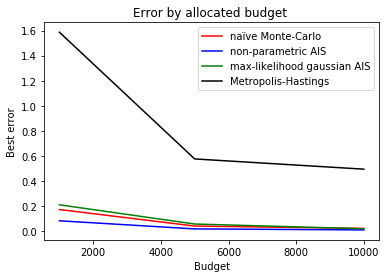

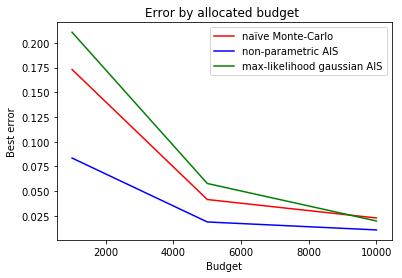

In [143]:
plt.figure()
Neval=[1000,5000,10000]
plt.plot(Neval,[MCK,MC5K,MC10K],'r',label='naïve Monte-Carlo')
plt.plot(Neval,[NAISk[-1],NAIS5k[-1],NAIS10k[-1]],'b',label="non-parametric AIS")
plt.plot(Neval,[avg_eval_likely_batch[0][-1],avg_eval_likely_batch[1][-1],avg_eval_likely_batch[2][-1]],'g',label="max-likelihood gaussian AIS")
plt.plot(Neval,[Xk,X5k,X10k],'k',label="Metropolis-Hastings")
plt.title("Error by allocated budget ")
plt.legend(loc='upper right')
plt.xlabel("Budget")
plt.ylabel("Best error")

plt.figure()
plt.plot(Neval,[MCK,MC5K,MC10K],'r',label='naïve Monte-Carlo')
plt.plot(Neval,[NAISk[-1],NAIS5k[-1],NAIS10k[-1]],'b',label="non-parametric AIS")
plt.plot(Neval,[avg_eval_likely_batch[0][-1],avg_eval_likely_batch[1][-1],avg_eval_likely_batch[2][-1]],'g',label="max-likelihood gaussian AIS")
plt.title("Error by allocated budget ")
plt.legend(loc='upper right')
plt.xlabel("Budget")
plt.ylabel("Best error")

The best method is finally the non-parametric estimation as expected since it approaches best the optimal sampler.

We find it interesting to compare the error at each iteration of our non parametric and gaussian likelihood AIS alogorithms to observe the variations of the error. We do this comparaison below

Text(0.5,1,'Evolution of the average error at each iteration')

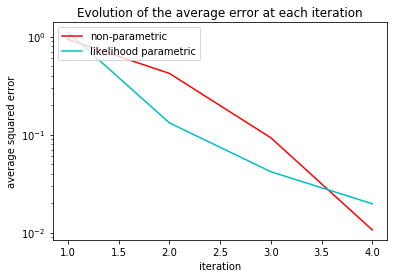

In [145]:
plt.figure()
plt.semilogy([i+1 for i in range(4)],NAIS10k,'r',label='non-parametric')
plt.semilogy([i+1 for i in range(4)],avg_eval_likely_batch[2],'c',label='likelihood parametric')
plt.xlabel("iteration")
plt.ylabel("average squared error")
plt.legend(loc='upper left')
plt.title('Evolution of the average error at each iteration')

We see that that the non-parametric error decreases a lot faster with the number of iterations. This is due to the fact that the sampler converges to the optimal sampler whit a lot of iterations. On the other hand we see that the speed decreases with the parametric estimator which is due to the fact that the sampler converges quickly and is still quite different from the optimal estimator, which causes the variance to increase.

# 3) A larger dimension?

Provide a deescription of your algorithm (if different than before).
Evaluate its performance when computing the average of mixture_d_5 with different sample sizes $(1000, 5000, 10000)$. You will use again the average squared error computed over at least 5050 trials.


In [150]:
def mixture_d_5(x):
    return (.5 * np.exp(-sum((x - np.array([3,5,0,0,0]))**2)/2) + .5 * np.exp(-sum((x - np.array([7,5,0,0,0]))**2)/2))/((2*np.pi)**(5/2))
true_mu = np.array([5,5,0,0,0])

We proceed to the same calculations as in the previous parts but in another dimension to see which algorithm is more susceptible to a variation of the dimension but for computation time's sake we only use 10 trial.

In [171]:
MCK2  = 0
MC5K2 = 0
MC10K2= 0 

def random_eval5(dim):
    x = np.array((np.random.uniform(0,10) , np.random.uniform(0,10), np.random.uniform(0,10), np.random.uniform(0,10), np.random.uniform(0,10)))
    return mixture_d_5(x)*10**dim*x

def MC(budget,func,dim):
    s = np.zeros(dim)
    for i in range(budget):
        #X = np.array([[np.random.uniform(-10,10) for j in range(dim)] for i in range(budget)])
        s+= random_eval5(dim)
    s/=budget
    return s

for i in range(10):
    MCK2   += ((MC(1000,mixture_d_5,5)-true_mu)**2).sum()
    MC5K2  += ((MC(5000,mixture_d_5,5)-true_mu)**2).sum()
    MC10K2 +=((MC(10000,mixture_d_5,5)-true_mu)**2).sum()

MCK2   /=10
MC5K2  /=10
MC10K2 /=10


##

avg_eval_likely_batch2 = np.zeros((3,4))

for j in range(10):
    avg_eval_likely_batch2[0] += np.sum((likelihood_eval_batch(1000,mixture_d_5,5,4)-true_mu)**2,axis=1)
    avg_eval_likely_batch2[1] += np.sum((likelihood_eval_batch(5000,mixture_d_5,5,4)-true_mu)**2,axis=1)
    avg_eval_likely_batch2[2] += np.sum((likelihood_eval_batch(10000,mixture_d_5,5,4)-true_mu)**2,axis=1)
    
avg_eval_likely_batch2 /= 10

##

NAISk2   = np.zeros(4)
NAIS5k2  = np.zeros(4)
NAIS10k2 = np.zeros(4)

for i in range(10):
    NAISk2   += ((normalised_AIS(budget_split(1000,4),mixture_d_5,5,[4,2,1,0.5],False)-true_mu)**2).sum(axis=1)
    NAIS5k2  += ((normalised_AIS(budget_split(5000,4),mixture_d_5,5,[4,2,1,0.5],False)-true_mu)**2).sum(axis=1)
    NAIS10k2 += ((normalised_AIS(budget_split(10000,4),mixture_d_5,5,[4,2,1,0.5],False)-true_mu)**2).sum(axis=1)
    
NAISk2   /= 10
NAIS5k2  /= 10
NAIS10k2 /= 10

##

for n in [1000,5000,10000]:
    Xs = 0
    for i in range(10):
        X1 = multi_metro_hasting(n,mixture_d_5,5,int(n/10),2)
        X1 = np.array(X1)
        Xs+=np.sum((np.sum(X1,axis=1)/X1.shape[1]- true_mu)**2)
    if n == 1000:
        Xk=Xs/10
    if n == 5000:
        X5k=Xs/10
    if n == 10000:
        X10k=Xs/10
        

In [174]:
print("Error for non-parametric estimation: ",NAIS10k2[-1])
print("Error for likelihood paramtric estimator : ",avg_eval_likely_batch2[2][-1])
print("Error for Metropolis-Hastings: ",X10k)
print("Error for uniform Monte-Carlo: ",MC10K2)

Error for non-parametric estimation:  0.011524105259710187
Error for likelihood paramtric estimator :  0.5714059097533181
Error for Metropolis-Hastings:  1.06070776300161
Error for uniform Monte-Carlo:  39.46161828132453


Text(0,0.5,'average squared error')

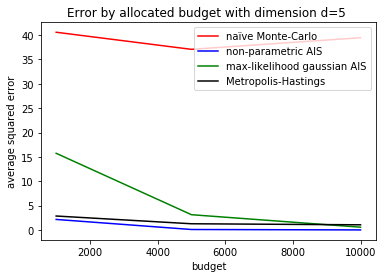

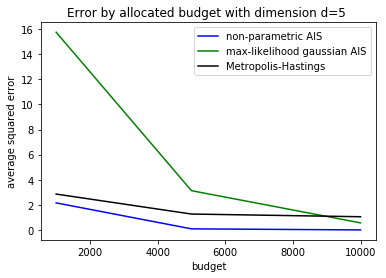

In [175]:
plt.figure()
Neval=[1000,5000,10000]
plt.plot(Neval,[MCK2,MC5K2,MC10K2],'r',label='naïve Monte-Carlo')
plt.plot(Neval,[NAISk2[-1],NAIS5k2[-1],NAIS10k2[-1]],'b',label="non-parametric AIS")
plt.plot(Neval,[avg_eval_likely_batch2[0][-1],avg_eval_likely_batch2[1][-1],avg_eval_likely_batch2[2][-1]],'g',label="max-likelihood gaussian AIS")
plt.plot(Neval,[Xk,X5k,X10k],'k',label="Metropolis-Hastings")
plt.title("Error by allocated budget with dimension d=5 ")
plt.legend(loc='upper right')
plt.xlabel("budget")
plt.ylabel("average squared error")

plt.figure()
Neval=[1000,5000,10000]
plt.plot(Neval,[NAISk2[-1],NAIS5k2[-1],NAIS10k2[-1]],'b',label="non-parametric AIS")
plt.plot(Neval,[avg_eval_likely_batch2[0][-1],avg_eval_likely_batch2[1][-1],avg_eval_likely_batch2[2][-1]],'g',label="max-likelihood gaussian AIS")
plt.plot(Neval,[Xk,X5k,X10k],'k',label="Metropolis-Hastings")
plt.title("Error by allocated budget with dimension d=5 ")
plt.legend(loc='upper right')
plt.xlabel("budget")
plt.ylabel("average squared error")

# 4) Conclusions

Experimenting in dimension 5 gives us interesting results. First we see that the non-parametric model is still the best type of sampler, the error manages to remain very consistantly low, the performances have not been affected by the dimension. The likelihood estimator also gives us similar results in both case. Adaptive sampling seems to be generally an effective way to solve these kind of problems. Metropolis-Hastings still does not give satisfying results. Finally, because the probability of falling in the interesting regions of the space decreases with the dimension, the uniform Monte-Carlo estimator's performance drastically fell. This type of estimator should not be used.

Our tests have concluded that if precision is most important requirement for the method, the non-parametric estimator performs best. These observations are coherent with what we know about the asymptotics of convolutions. However, if other criteria such as computation time are more important, the most efficient would be to use a likelihood estimator.